In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
# import joypy

from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

from stopsignalmetrics import SSRTmodel
from SimulateData import SimulateData
from utils import joyplot


%matplotlib inline

## general simulation testing

/Users/henrymj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
/Users/henrymj/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/henrymj/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/henrymj/Documents/abcd/utils.py:228: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")
/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/henrymj/anaconda3/lib/python3.7/site-packages/n

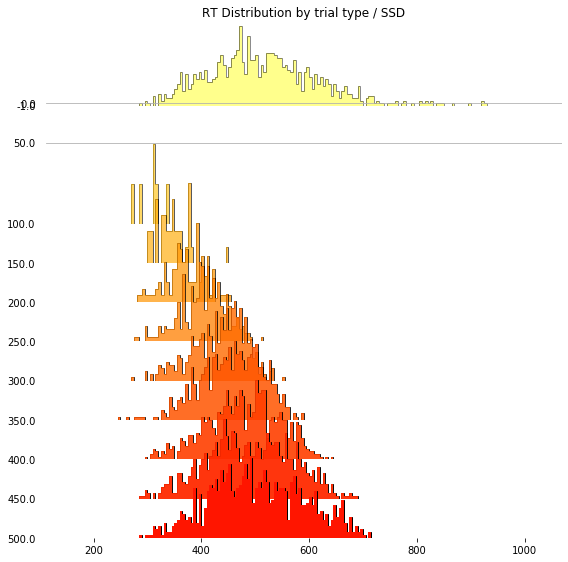

In [2]:
simulator = SimulateData()
sim_data = simulator.simulate()

SSDs = sim_data.SSD.unique()
SSDs = [i for i in SSDs if i==i]
SSDs.sort()
RT_dist_dict = {ssd: [] for ssd in SSDs}
for ssd in SSDs:
    RT_dist_dict[ssd] = sim_data.query(
        f"SSD == {ssd}"
    ).stopRT.values

go_RTs = sim_data.query(
        f"condition == 'go'"
    ).goRT.values

RT_dist_dict.update({-1:go_RTs})

max_RT = np.nanmax([np.nanmax(RT_dist_dict[key]) for key in RT_dist_dict])

bins = np.arange(0, max_RT, 5)
prob_dict = {key: [] for key in RT_dist_dict}
between_bin_dict = {key: [] for key in RT_dist_dict}
for key in RT_dist_dict:
    ps, bins, _= plt.hist(RT_dist_dict[key], bins=bins, density=True)
    prob_dict[key] = ps
    between_bin_dict[key] = [np.mean([p1, p2]) for p1, p2 in zip(ps[:-1], ps[1:])]
    plt.close()

RT_by_SSD_df = pd.DataFrame({ key:pd.Series(value) for key, value in RT_dist_dict.items()})
RT_by_SSD_df = RT_by_SSD_df.reindex(sorted(RT_by_SSD_df.columns), axis=1)
rt_by_SSD_melt = RT_by_SSD_df.melt(value_vars=RT_by_SSD_df.columns, var_name='SSD', value_name='RT')

fig, axes = joyplot(rt_by_SSD_melt, by="SSD", column="RT", range_style='own',
                    grid='y',
                    linewidth=1, legend=False, figsize=(8,8),
                    title="RT Distribution by trial type / SSD",
                    bins=bins,
                    hist=True,
                    density=True,
                    ylim='own',
                    colormap=cm.autumn_r,
                    fade=True)
plt.show()
plt.close()

# GET ABCD INFO

In [3]:
abcd_data = pd.read_csv('minimal_abcd_no_issue_3.csv')

## get P(guess) mixing proportions

In [4]:
SSDs = abcd_data.SSDDur.unique()
SSDs = [i for i in SSDs if i==i and i <=550]
SSDs.sort()
acc_per_SSD = pd.DataFrame()
for ssd in SSDs:
    curr_means = abcd_data.query(
        f"SSDDur == {ssd} and correct_stop==0.0"
    ).groupby('NARGUID').mean()['choice_accuracy']
    curr_means.name = ssd
    acc_per_SSD = pd.concat([acc_per_SSD, curr_means], 1, sort=True)

go_accs = abcd_data.query(
        f"trial_type == 'GoTrial' and correct_go_response in ['1.0', '0.0']"
    ).groupby('NARGUID').mean()['choice_accuracy']
go_accs.name = -1
acc_per_SSD = pd.concat([acc_per_SSD, go_accs], 1, sort=True)

In [5]:
p = Symbol('p')
guess_mean = acc_per_SSD.mean()[0.0]
go_mean = acc_per_SSD.mean()[-1]
p_guess_per_SSD = []
for ssd in acc_per_SSD.columns:
    curr_mean = acc_per_SSD.mean()[ssd]
    solution = solve(p*guess_mean + (1-p)*go_mean - curr_mean, p)
    assert len(solution)==1
    p_guess_per_SSD.append(solution[0])

## Getting expnorm info

In [ ]:
def generate_exgauss_sampler_from_fit(data,
                                      default_sample_size=100000):
    FIT_K, FIT_LOC, FIT_SCALE  = sstats.exponnorm.fit(data)
    FIT_mean = FIT_LOC + FIT_K*FIT_SCALE
    FIT_λ = 1/(FIT_K*FIT_SCALE)
    FIT_BETA = 1/FIT_λ

    def sample_exgauss(sample_size=default_sample_size, beta=FIT_BETA, scale=FIT_SCALE, loc=FIT_LOC):
        exp_out = np.random.exponential(scale=beta, size=sample_size)
        norm_out = np.random.normal(scale=scale, size=sample_size)
        return (exp_out+norm_out) + loc
    
    return sample_exgauss
    
SSD0_RTs = abcd_data.query("SSDDur == 0.0 and correct_stop==0.0").stop_rt_adjusted.values
sample_exgauss = generate_exgauss_sampler_from_fit(SSD0_RTs)

# SIMULATE

In [ ]:
nsubjects = 75
subjects = np.arange(0, nsubjects)

simulator_dict = {
    'vanilla': SimulateData(),
    'guesses': SimulateData(guesses=True),
    'graded_mu_go': SimulateData(graded_mu_go=True)
}

group_data_dict = {
    'vanilla': pd.DataFrame(),
    'guesses': pd.DataFrame(),
    'graded_mu_go': pd.DataFrame()
}

for subject in subjects:
    params={
        'n_trials': 50,
        'SSDs': SSDs, 
        'mu_go': np.random.normal(.2, scale=.03),
        'mu_stop': np.random.normal(.65, scale=.03),
        'guess_function': sample_exgauss,
        'p_guess': p_guess_per_SSD[:-1] # ignore go trials, for now
    }
    for sim_key in simulator_dict:
        data = simulator_dict[sim_key].simulate(params)
        data['ID'] = subject
        group_data_dict[sim_key] = pd.concat([group_data_dict[sim_key], data],0)

In [ ]:
full_data = pd.DataFrame()
for stim_key in group_data_dict:
    curr_group = group_data_dict[stim_key].copy()
    curr_group['simulation'] = stim_key
    curr_group.to_csv('Simulated_Data/%s.csv' % stim_key)
    full_data = pd.concat([full_data, curr_group])
full_data.to_csv('Simulated_Data/full.csv')

In [ ]:
ssrt_data = pd.DataFrame()
for stim_key in group_data_dict:
    curr_group = SSRTmodel().fit_transform(group_data_dict[stim_key], level='group').reset_index()
    curr_group['simulation'] = stim_key
    ssrt_data = pd.concat([ssrt_data, curr_group])
    
ssrt_data = ssrt_data.reset_index(drop=True)
sns.boxplot(x=ssrt_data['simulation'], y=ssrt_data['SSRT'],showmeans=True, fliersize=1 )    

In [ ]:
for sim_key in group_data_dict:
    sim_data = group_data_dict[sim_key]

    SSDs = sim_data.SSD.unique()
    SSDs = [i for i in SSDs if i==i]
    SSDs.sort()
    RT_dist_dict = {ssd: [] for ssd in SSDs}
    for ssd in SSDs:
        RT_dist_dict[ssd] = sim_data.query(
            f"SSD == {ssd}"
        ).stopRT.values

    go_RTs = sim_data.query(
            f"condition == 'go'"
        ).goRT.values

    RT_dist_dict.update({-1:go_RTs})

    max_RT = np.nanmax([np.nanmax(RT_dist_dict[key]) for key in RT_dist_dict])

    bins = np.arange(0, max_RT, 5)
    prob_dict = {key: [] for key in RT_dist_dict}
    between_bin_dict = {key: [] for key in RT_dist_dict}
    for key in RT_dist_dict:
        ps, bins, _= plt.hist(RT_dist_dict[key], bins=bins, density=True)
        prob_dict[key] = ps
        between_bin_dict[key] = [np.mean([p1, p2]) for p1, p2 in zip(ps[:-1], ps[1:])]
        plt.close()

    RT_by_SSD_df = pd.DataFrame({ key:pd.Series(value) for key, value in RT_dist_dict.items()})
    RT_by_SSD_df = RT_by_SSD_df.reindex(sorted(RT_by_SSD_df.columns), axis=1)
    rt_by_SSD_melt = RT_by_SSD_df.melt(value_vars=RT_by_SSD_df.columns, var_name='SSD', value_name='RT')

    fig, axes = joyplot(rt_by_SSD_melt, by="SSD", column="RT", range_style='own', 
                        grid="y", linewidth=1, legend=False, figsize=(8,8),
                        title="[%s] RT Distribution by trial type / SSD" % sim_key,
                        bins=bins,
                        ylim='own',
                        colormap=cm.autumn_r,
                        fade=True,
                        hist=True,
                        density=True)
    plt.show()
    plt.close()